In [1]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: prajwalhiremath
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mssmartypants/rice-type-classification


100%|██████████| 888k/888k [00:00<00:00, 1.25GB/s]

In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
data_df = pd.read_csv("/content/rice-type-classification/riceClassification.csv")

In [4]:
data_df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [5]:
print("Before drop",data_df.shape)
data_df.drop(['id'], axis=1, inplace=True)
print("After drop",data_df.shape)

Before drop (18185, 12)
After drop (18185, 11)


In [6]:
data_df["Class"].value_counts()

,count
Class,
1,9985
0,8200


In [7]:
original_df = data_df.copy()
for col in data_df.columns:
  data_df[col] = data_df[col]/data_df[col].abs().max()
data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [8]:
X  = np.array(data_df.iloc[:, :-1]) #all the rows, all the columns except the last one
y = np.array(data_df.iloc[:, -1])

In [9]:
X

array([[0.44436827, 0.50340371, 0.77543522, ..., 0.5370287 , 0.844997  ,
        0.36831616],
       [0.28129285, 0.40768133, 0.62265269, ..., 0.40966075, 0.91921498,
        0.37147093],
       [0.29853085, 0.41642141, 0.63044229, ..., 0.41299402, 0.95986205,
        0.37474651],
       ...,
       [0.62340842, 0.84480035, 0.64091576, ..., 0.67304935, 0.75472018,
        0.74783024],
       [0.58374143, 0.8263563 , 0.62355087, ..., 0.67524793, 0.70210346,
        0.75187447],
       [0.60078355, 0.83554818, 0.62495614, ..., 0.6658912 , 0.74305096,
        0.7585284 ]])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [11]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

In [12]:
X_test.shape

(2728, 10)

## Convert np dataset to pytorch dataset

In [13]:
class dataset(Dataset):
  def __init__(self, X, Y):
    self.X = torch.tensor(X, dtype=torch.float32).to(device)
    self.Y = torch.tensor(Y, dtype=torch.float32).to(device)
  def __len__(self):
    return len(self.X)
  def __getitem__(self, index):
    return self.X[index], self.Y[index]

In [14]:
training_data = dataset(X_train, y_train)
validation_data = dataset(X_val, y_val)
testing_data = dataset(X_test, y_test)

In [15]:
BATCH_SIZE = 32
EPOCHS = 10
HIDDEN_NEURONS = 10
LR = 1e-3

In [16]:
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle=True)
testing_dataloader = DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle=True)

## Buiding the model

In [17]:
class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()
    self.input_layer = nn.Linear(X.shape[1], HIDDEN_NEURONS)
    self.linear = nn.Linear(HIDDEN_NEURONS, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.input_layer(x)
    x = self.linear(x)
    x = self.sigmoid(x)
    return x

model = MyModel().to(device)

In [18]:
summary(model, (X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [19]:
criterion = nn.BCELoss() #binary cross entropy loss
optimizer = Adam(model.parameters(), lr = LR)

## Training

In [20]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []


for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0
  total_acc_val = 0
  total_loss_val = 0

  for data in train_dataloader:
    inputs, labels = data

    prediction = model(inputs).squeeze(1) #will change prediction.shape -> [8,1] to prediction.shape -> [8]

    batch_loss = criterion(prediction, labels)

    total_loss_train += batch_loss.item()

    acc = ((prediction).round() == labels).sum().item() #.item will give integer, .sum() will have the value along with tensor

    total_acc_train += acc

    batch_loss.backward()
    optimizer.step() #we are saying optimizer take a step and change the steps
    optimizer.zero_grad() #after the optimizer changes the weight in the batch, the optimizer restart again.

  with torch.no_grad(): #use pytorch model not for training. Here no weights will changed
    for data in validation_dataloader:
      inputs, labels = data

      prediction = model(inputs).squeeze(1)
      batch_loss = criterion(prediction, labels)

      total_loss_val += batch_loss.item()
      acc = ((prediction).round() == labels).sum().item()

      total_acc_val += acc
  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_val/1000, 4))

  total_acc_train_plot.append(round(total_acc_train/(training_data.__len__())* 100, 4))
  total_acc_validation_plot.append(round(total_acc_val/(validation_data.__len__())* 100, 4))


  print(f"""Epoch no. {epoch+1} Train Loss : {round(total_loss_train/1000, 4)} Train Accuray :{round(total_acc_train/(training_data.__len__()) * 100, 4)}
          Validation loss : {round(total_loss_val/1000, 4)} Validation Accuracy : {round(total_acc_val/(validation_data.__len__()) * 100, 4)}""")

  print("="*25)





Epoch no. 1 Train Loss : 0.2434 Train Accuray :81.224
          Validation loss : 0.0413 Validation Accuracy : 97.2141
Epoch no. 2 Train Loss : 0.1279 Train Accuray :98.146
          Validation loss : 0.0173 Validation Accuracy : 97.9106
Epoch no. 3 Train Loss : 0.0575 Train Accuray :98.4524
          Validation loss : 0.0095 Validation Accuracy : 98.1672
Epoch no. 4 Train Loss : 0.0355 Train Accuray :98.5623
          Validation loss : 0.007 Validation Accuracy : 98.2038
Epoch no. 5 Train Loss : 0.027 Train Accuray :98.6016
          Validation loss : 0.0057 Validation Accuracy : 98.4238
Epoch no. 6 Train Loss : 0.0226 Train Accuray :98.6959
          Validation loss : 0.0049 Validation Accuracy : 98.4604
Epoch no. 7 Train Loss : 0.0202 Train Accuray :98.7273
          Validation loss : 0.0045 Validation Accuracy : 98.5704
Epoch no. 8 Train Loss : 0.0187 Train Accuray :98.6723
          Validation loss : 0.0043 Validation Accuracy : 98.607
Epoch no. 9 Train Loss : 0.0176 Train Accuray

## Testing

In [21]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0

  for data in testing_dataloader:
    inputs, labels = data

    prediction = model(inputs).squeeze(1)

    batch_loss_test = criterion(prediction, labels).item()
    total_loss_test += batch_loss_test

    acc = ((prediction).round() == labels).sum().item()

    total_acc_test += acc

print("Accuracy:", round(total_acc_test/(testing_data.__len__()) * 100, 4))

Accuracy: 98.5337


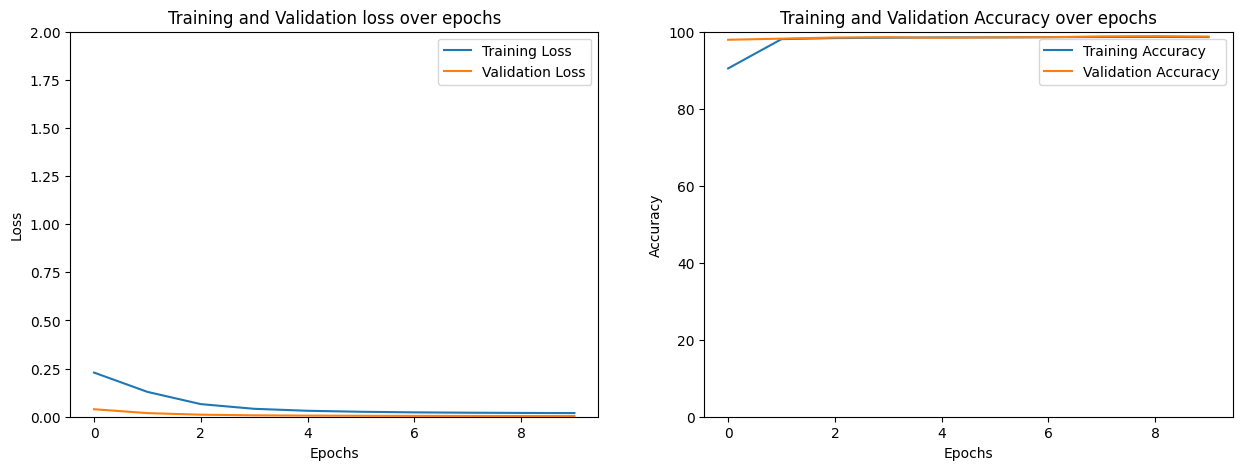

In [22]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

axs[0].plot(total_loss_train_plot, label="Training Loss")
axs[0].plot(total_loss_validation_plot, label="Validation Loss")
axs[0].set_title("Training and Validation loss over epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_ylim([0,2])
axs[0].legend()


axs[1].plot(total_acc_train_plot, label="Training Accuracy")
axs[1].plot(total_acc_validation_plot, label="Validation Accuracy")
axs[1].set_title("Training and Validation Accuracy over epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_ylim([0,100])
axs[1].legend()

plt.show()

# The same problem for Production Approach

In [23]:
!pip install torchmetrics --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 27.7 MB/s eta 0:00:00


In [24]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import torchmetrics  # For better metric calculation
import matplotlib.pyplot as plt

# Device setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


### Data loading and spliting

In [25]:
# Load
data_df = pd.read_csv("/content/rice-type-classification/riceClassification.csv")
data_df = data_df.drop('id', axis=1)

# Separate features (X) and target (y)
X = data_df.drop('Class', axis=1)
y = data_df['Class']

# Create a 3-way split (Train, Validation, Test)
# Note: stratify=y is CRITICAL. It ensures the class balance (55/45)
# is preserved in all three of your splits.
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Train shape: {X_train.shape}, Val shape: {X_val.shape}, Test shape: {X_test.shape}")

Train shape: (12729, 10), Val shape: (2728, 10), Test shape: (2728, 10)


### Feature Engineering

In [26]:
# 1. Define the preprocessing pipeline
#    For this data, we just need to scale all numeric features.
preprocessor = Pipeline([
    ('scaler', StandardScaler())
])

# 2. Fit the pipeline ONLY on the training data
X_train_scaled = preprocessor.fit_transform(X_train)

# 3. Transform the val and test data using the *same* (fitted) pipeline
X_val_scaled = preprocessor.transform(X_val)
X_test_scaled = preprocessor.transform(X_test)

In [31]:
print(type(y_train.values))
print(type(y_train))
print(type(X_t))

<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


### Scalable Dataloaders

In [32]:
# Convert numpy arrays to torch tensors
# We keep them as float32 for the model and long for the labels
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32)
X_val_t = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_t = torch.tensor(y_val.values, dtype=torch.float32)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
test_dataset = TensorDataset(X_test_t, y_test_t)

# Create DataLoaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Production Model

In [33]:
class ProductionModel(nn.Module):
    def __init__(self, input_features, hidden_units):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(input_features, hidden_units),
            nn.ReLU(),  # <--- Added Non-linearity
            nn.Dropout(0.3),  # <--- Added Regularization
            nn.Linear(hidden_units, hidden_units // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_units // 2, 1) # <--- Output is raw logits
        )

    def forward(self, x):
        return self.layer_stack(x)

# Note: X_train_scaled.shape[1] is the number of input features (10)
model = ProductionModel(
    input_features=X_train_scaled.shape[1],
    hidden_units=64  # Let's try a larger model
).to(device)

summary(model, (X_train_scaled.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]             704
              ReLU-2                   [-1, 64]               0
           Dropout-3                   [-1, 64]               0
            Linear-4                   [-1, 32]           2,080
              ReLU-5                   [-1, 32]               0
           Dropout-6                   [-1, 32]               0
            Linear-7                    [-1, 1]              33
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [33]:
# --- Hyperparameters ---
EPOCHS = 20
LR = 0.001

# --- Loss and Optimizer ---
# USE BCEWithLogitsLoss. It's numerically more stable than
# a separate Sigmoid layer + BCELoss. It expects RAW LOGITS.
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=LR)

# --- Metrics ---
# Use torchmetrics for reliable accuracy
train_acc = torchmetrics.Accuracy(task="binary").to(device)
val_acc = torchmetrics.Accuracy(task="binary").to(device)

# --- History ---
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}


for epoch in range(EPOCHS):
    # --- Training ---
    model.train() # <--- Set model to TRAINING mode (enables Dropout)
    train_loss = 0
    for X_batch, y_batch in train_loader:
        # Move THIS BATCH to the device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).unsqueeze(1)

        # 1. Forward pass
        y_logits = model(X_batch)

        # 2. Calculate loss
        loss = criterion(y_logits, y_batch)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # 6. Update accuracy
        train_acc.update(y_logits, y_batch)

    # Calculate average loss and acc for the epoch
    avg_train_loss = train_loss / len(train_loader)
    epoch_train_acc = train_acc.compute()
    train_acc.reset() # Reset for next epoch

    # --- Validation ---
    model.eval() # <--- Set model to EVALUATION mode (disables Dropout)
    val_loss = 0
    with torch.no_grad():
        for X_batch_val, y_batch_val in val_loader:
            X_batch_val, y_batch_val = X_batch_val.to(device), y_batch_val.to(device).unsqueeze(1)

            y_val_logits = model(X_batch_val)
            loss = criterion(y_val_logits, y_batch_val)
            val_loss += loss.item()
            val_acc.update(y_val_logits, y_batch_val)

    avg_val_loss = val_loss / len(val_loader)
    epoch_val_acc = val_acc.compute()
    val_acc.reset()

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

    history["train_loss"].append(avg_train_loss)
    history["train_acc"].append(epoch_train_acc.item())
    history["val_loss"].append(avg_val_loss)
    history["val_acc"].append(epoch_val_acc.item())

Epoch 1/20 | Train Loss: 0.4944, Train Acc: 0.9795 | Val Loss: 0.4932, Val Acc: 0.9835
Epoch 2/20 | Train Loss: 0.4935, Train Acc: 0.9831 | Val Loss: 0.4921, Val Acc: 0.9857
Epoch 3/20 | Train Loss: 0.4932, Train Acc: 0.9837 | Val Loss: 0.4916, Val Acc: 0.9872
Epoch 4/20 | Train Loss: 0.4928, Train Acc: 0.9841 | Val Loss: 0.4917, Val Acc: 0.9864
Epoch 5/20 | Train Loss: 0.4926, Train Acc: 0.9845 | Val Loss: 0.4913, Val Acc: 0.9879
Epoch 6/20 | Train Loss: 0.4923, Train Acc: 0.9852 | Val Loss: 0.4913, Val Acc: 0.9872
Epoch 7/20 | Train Loss: 0.4921, Train Acc: 0.9852 | Val Loss: 0.4912, Val Acc: 0.9879
Epoch 8/20 | Train Loss: 0.4920, Train Acc: 0.9855 | Val Loss: 0.4910, Val Acc: 0.9886
Epoch 9/20 | Train Loss: 0.4918, Train Acc: 0.9857 | Val Loss: 0.4910, Val Acc: 0.9879
Epoch 10/20 | Train Loss: 0.4917, Train Acc: 0.9857 | Val Loss: 0.4911, Val Acc: 0.9879
Epoch 11/20 | Train Loss: 0.4915, Train Acc: 0.9862 | Val Loss: 0.4913, Val Acc: 0.9868
Epoch 12/20 | Train Loss: 0.4916, Train A

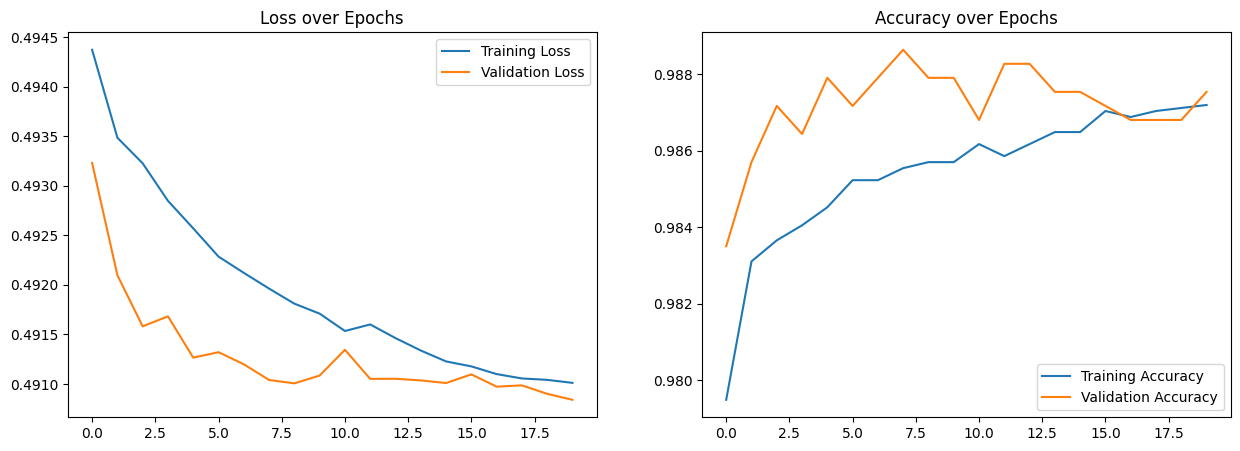

Final Test Accuracy: 0.9905


In [34]:
# Plot the history
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(history['train_loss'], label="Training Loss")
axs[0].plot(history['val_loss'], label="Validation Loss")
axs[0].set_title("Loss over Epochs")
axs[0].legend()

axs[1].plot(history['train_acc'], label="Training Accuracy")
axs[1].plot(history['val_acc'], label="Validation Accuracy")
axs[1].set_title("Accuracy over Epochs")
axs[1].legend()

plt.show()

# --- Final Test ---
# Evaluate the model on the unseen test set
test_acc = torchmetrics.Accuracy(task="binary").to(device)
model.eval()
with torch.no_grad():
    for X_batch_test, y_batch_test in test_loader:
        X_batch_test, y_batch_test = X_batch_test.to(device), y_batch_test.to(device).unsqueeze(1)
        y_test_logits = model(X_batch_test)
        test_acc.update(y_test_logits, y_batch_test)

final_test_accuracy = test_acc.compute()
print(f"Final Test Accuracy: {final_test_accuracy.item():.4f}")

# Tensorflow Production flow

In [35]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import joblib  # For saving the sklearn preprocessor
import matplotlib.pyplot as plt

# Check for GPU
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.19.0
Num GPUs Available:  1


In [36]:
# Load
data_df = pd.read_csv("/content/rice-type-classification/riceClassification.csv")
data_df = data_df.drop('id', axis=1)

# Separate features (X) and target (y)
X = data_df.drop('Class', axis=1)
y = data_df['Class']

# Create a 3-way split (Train, Validation, Test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

## Preprocessing

In [37]:
# 1. Define the preprocessing pipeline
preprocessor = Pipeline([
    ('scaler', StandardScaler())
])

# 2. Fit the pipeline ONLY on the training data
X_train_scaled = preprocessor.fit_transform(X_train)

# 3. Transform the val and test data
X_val_scaled = preprocessor.transform(X_val)
X_test_scaled = preprocessor.transform(X_test)

## Keras Model subclassing

In [38]:
class ProductionModel(keras.Model):
    def __init__(self, input_features, hidden_units):
        super().__init__()
        # Define the layers in the constructor
        self.dense1 = layers.Dense(hidden_units, activation="relu")
        self.dropout1 = layers.Dropout(0.3)
        self.dense2 = layers.Dense(hidden_units // 2, activation="relu")
        self.dropout2 = layers.Dropout(0.2)
        # Final output layer: 1 unit, NO activation (outputs logits)
        self.output_layer = layers.Dense(1)

    def call(self, x, training=False):
        # Define the forward pass in the 'call' method
        x = self.dense1(x)
        # The 'training' flag is crucial for Dropout
        # It tells Dropout to be active during training and inactive during inference
        x = self.dropout1(x, training=training)
        x = self.dense2(x)
        x = self.dropout2(x, training=training)
        return self.output_layer(x)

# --- Hyperparameters ---
INPUT_FEATURES = X_train_scaled.shape[1] # 10
HIDDEN_UNITS = 64
EPOCHS = 20
BATCH_SIZE = 32
LEARNING_RATE = 0.001

# Instantiate the model
model = ProductionModel(input_features=INPUT_FEATURES, hidden_units=HIDDEN_UNITS)

# You can even build it and see a summary
model.build(input_shape=(None, INPUT_FEATURES))
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'production_model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "production_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Dataloader to Tensorflow

In [39]:
# Create tf.data.Dataset objects
# from_tensor_slices is perfect for in-memory data
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train.values))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_scaled, y_val.values))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_scaled, y_test.values))

# Optimize the pipelines
train_dataset = train_dataset.shuffle(buffer_size=len(X_train_scaled))\
                             .batch(BATCH_SIZE)\
                             .prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.batch(BATCH_SIZE)\
                           .prefetch(tf.data.AUTOTUNE)

test_dataset = test_dataset.batch(BATCH_SIZE)\
                            .prefetch(tf.data.AUTOTUNE)

## Keras Training loop

In [41]:
# --- Loss, Optimizer, and Metrics ---

# 1. Loss: The direct equivalent of nn.BCEWithLogitsLoss
# It expects raw logits from the model.
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# 2. Optimizer:
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# 3. Metrics: Keras objects to track state
train_acc_metric = tf.keras.metrics.BinaryAccuracy()
val_acc_metric = tf.keras.metrics.BinaryAccuracy()
train_loss_metric = tf.keras.metrics.Mean()
val_loss_metric = tf.keras.metrics.Mean()

# Use @tf.function to compile these steps into a high-performance graph
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        # Get logits, making sure to set training=True for Dropout
        logits = model(x, training=True)
        # Ensure y has the same shape as logits [batch, 1]
        y_true = tf.expand_dims(tf.cast(y, tf.float32), axis=1)
        # Calculate loss
        loss = loss_fn(y_true, logits)

    # Calculate gradients and update weights
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    # Update metrics
    # We apply sigmoid here *only for the accuracy metric*
    train_acc_metric.update_state(y_true, tf.nn.sigmoid(logits))
    train_loss_metric.update_state(loss)
    return loss

@tf.function
def val_step(x, y):
    # Get logits, setting training=False to disable Dropout
    val_logits = model(x, training=False)
    y_true = tf.expand_dims(tf.cast(y, tf.float32), axis=1)

    # Calculate loss and update metrics
    loss = loss_fn(y_true, val_logits)
    val_acc_metric.update_state(y_true, tf.nn.sigmoid(val_logits))
    val_loss_metric.update_state(loss)

# --- The Main Loop ---
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(EPOCHS):
    # --- Training ---
    for x_batch, y_batch in train_dataset:
        train_step(x_batch, y_batch)

    # --- Validation ---
    for x_batch_val, y_batch_val in val_dataset:
        val_step(x_batch_val, y_batch_val)

    # Get and print results
    train_loss = train_loss_metric.result()
    train_acc = train_acc_metric.result()
    val_loss = val_loss_metric.result()
    val_acc = val_acc_metric.result()

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save history
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    # Reset metrics for the next epoch!
    train_acc_metric.reset_state()
    val_acc_metric.reset_state()
    train_loss_metric.reset_state()
    val_loss_metric.reset_state()

Epoch 1/20 | Train Loss: 0.0396, Train Acc: 0.9865 | Val Loss: 0.0335, Val Acc: 0.9890
Epoch 2/20 | Train Loss: 0.0381, Train Acc: 0.9871 | Val Loss: 0.0333, Val Acc: 0.9901
Epoch 3/20 | Train Loss: 0.0365, Train Acc: 0.9888 | Val Loss: 0.0333, Val Acc: 0.9905
Epoch 4/20 | Train Loss: 0.0376, Train Acc: 0.9882 | Val Loss: 0.0324, Val Acc: 0.9905
Epoch 5/20 | Train Loss: 0.0361, Train Acc: 0.9881 | Val Loss: 0.0327, Val Acc: 0.9897
Epoch 6/20 | Train Loss: 0.0353, Train Acc: 0.9889 | Val Loss: 0.0325, Val Acc: 0.9901
Epoch 7/20 | Train Loss: 0.0346, Train Acc: 0.9883 | Val Loss: 0.0324, Val Acc: 0.9905
Epoch 8/20 | Train Loss: 0.0350, Train Acc: 0.9889 | Val Loss: 0.0319, Val Acc: 0.9908
Epoch 9/20 | Train Loss: 0.0335, Train Acc: 0.9891 | Val Loss: 0.0326, Val Acc: 0.9897
Epoch 10/20 | Train Loss: 0.0343, Train Acc: 0.9886 | Val Loss: 0.0329, Val Acc: 0.9897
Epoch 11/20 | Train Loss: 0.0335, Train Acc: 0.9892 | Val Loss: 0.0335, Val Acc: 0.9897
Epoch 12/20 | Train Loss: 0.0341, Train A

In [42]:
# 1. Save the sklearn preprocessor
joblib.dump(preprocessor, 'rice_preprocessor.joblib')

# 2. Save the TensorFlow model weights
model.save_weights('rice_model_tf_weights.weights.h5')

print("Model and preprocessor saved.")

Model and preprocessor saved.


## Inference

In [48]:
# --- 1. Load the artifacts ---
print("\n--- Starting Inference ---")
# Create a new instance of the model
inference_model = ProductionModel(input_features=INPUT_FEATURES, hidden_units=HIDDEN_UNITS)
# Build the model
inference_model.build(input_shape=(None, INPUT_FEATURES))
# Load the saved weights
inference_model.load_weights('/content/rice_model_tf_weights.weights.h5')

# Load the saved preprocessor
loaded_preprocessor = joblib.load('/content/rice_preprocessor.joblib')

# --- 2. Get new, raw data ---
# Let's grab one sample from our *unscaled* test set (as a pandas Series)
raw_new_sample_data = X_test.iloc[0]
print(f"Raw Input Data:\n{raw_new_sample_data}")
print(f"True Class: {y_test.iloc[0]}")

# --- 3. Apply Preprocessing ---
# The preprocessor expects a 2D array, so we convert the Series
# [raw_new_sample_data] creates a list with the Series,
# and the DataFrame constructor converts it to a 1-row DataFrame.
raw_df = pd.DataFrame([raw_new_sample_data])
scaled_data = loaded_preprocessor.transform(raw_df)

# Convert to a TensorFlow tensor
input_tensor = tf.convert_to_tensor(scaled_data, dtype=tf.float32)
print(f"\nScaled Input Tensor shape: {input_tensor.shape}")

# --- 4. Make Prediction ---
# Set training=False to ensure Dropout is off!
logit_output = inference_model(input_tensor, training=False)
logit_value = logit_output.numpy()[0][0] # Get the single number

# --- 5. Interpret the Output ---
# Convert the logit to a probability
probability = tf.nn.sigmoid(logit_output).numpy()[0][0]

# Convert the probability to a class
if probability > 0.5:
    prediction = 1
    class_name = "Jasmine" # Assuming 1 is Jasmine
else:
    prediction = 0
    class_name = "Gonen"   # Assuming 0 is Gonen

print("\n--- Prediction Results ---")
print(f"Raw Logit: {logit_value:.4f}")
print(f"Probability: {probability:.4f}")
print(f"Predicted Class: {prediction} ({class_name})")


--- Starting Inference ---
Raw Input Data:
Area               8491.000000
MajorAxisLength     152.758821
MinorAxisLength      71.598276
Eccentricity          0.883357
ConvexArea         8715.000000
EquivDiameter       103.976329
Extent                0.662531
Perimeter           366.568000
Roundness             0.794071
AspectRation          2.133554
Name: 12101, dtype: float64
True Class: 0

Scaled Input Tensor shape: (1, 10)

--- Prediction Results ---
Raw Logit: 0.2084
Probability: 0.5519
Predicted Class: 1 (Jasmine)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'production_model_5', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
